In [1]:
import warnings
warnings.filterwarnings("ignore")

### Imports

In [2]:
import finnhub
from datetime import datetime
from datetime import timezone
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def get_EMA(stock, ema_s, ema_l):
    stock["EMA_S"] = stock.Close.ewm(span = ema_s, min_periods = ema_s).mean()
    stock["EMA_L"] = stock.Close.ewm(span = ema_l, min_periods = ema_l).mean()
    return stock

In [4]:
def get_ATR(stock, n):
    hl = stock.High - stock.Low
    hc = abs(stock.High - stock.Close.shift(1))
    lc = abs(stock.Low - stock.Close.shift(1))
    
    stock.loc[:,'TR'] = np.maximum(np.maximum(hl, hc), lc)
    stock.loc[:,'ATR'] = stock.TR.rolling(n).mean()
    
    return stock

In [5]:
def EMA_ATR(stock, ema_s, ema_l, atr_n, atr_mul):
    
    stock = get_EMA(stock, ema_s, ema_l)
    stock = get_ATR(stock, atr_n)
    stock = stock.dropna(axis = 0)

    stock = stock.assign(ATR_stop_l = (stock['Close'] - atr_mul * stock['ATR']).shift(1))
    stock = stock.assign(ATR_stop_s = (stock['Close']  + atr_mul * stock['ATR']).shift(1))
    
    stock = stock.dropna(axis = 0)
    
    # position
    stock['pos'] = 0
    stock['pos'] = np.where((stock.EMA_S > stock.EMA_L)\
                            & (stock.Close > stock.ATR_stop_l), 1, 0)
    npos = (stock.pos == 0)
    stock.loc[npos, 'pos'] = np.where((stock.loc[npos, 'Close'] < stock.loc[npos, 'ATR_stop_s']), -1, 0)
    
    # cumulative return
    # daily log return
    stock.loc[:,'rtn'] = np.log(stock.Close.div(stock.Close.shift(1))) # without strategy
    stock.loc[:,'s_rtn'] = stock.pos.shift(1) * stock.rtn # with strategy

    stock = stock.dropna(axis = 0)

    # cumulative return
    stock['crtn'] = stock['rtn'].cumsum().apply(np.exp) # without strategy
    stock['s_crtn'] = stock['s_rtn'].cumsum().apply(np.exp) # with strategy
    
    # Entry and Exit
    stock['EE_ATR_L'] = 0 # entry and exit for long trade
    stock['EE_ATR_S'] = 0 # entry and exit for short trade
    ts_l = 0 # trading signal for long trade
    ts_s = 0 # trading signal for short trade
    pre = 0 # previous close price
    for i in stock.index:
        
        # long trade entry
        if ((stock.loc[i, 'EMA_S'] >= stock.loc[i, 'EMA_L'])\
            & (ts_l == 0)\
            & (stock.loc[i, 'Close'] > stock.loc[i, 'ATR_stop_l'])):
            ts_l = 1
            stock.loc[i, 'EE_ATR_L'] = 1
        
        # long trade exit
        if (((stock.loc[i, 'EMA_S'] < stock.loc[i, 'EMA_L'])\
             | (stock.loc[i, 'Close'] <= stock.loc[i, 'ATR_stop_l']))\
            & (ts_l == 1)):
            ts_l = 0
            stock.loc[i, 'EE_ATR_L'] = -1
            
        # short trade entry
        if (((stock.loc[i, 'EMA_S'] < stock.loc[i, 'EMA_L'])\
             | (stock.loc[i, 'Close'] < stock.loc[i, 'ATR_stop_s']))\
            & (ts_s == 0)):
            ts_s = 1
            stock.loc[i, 'EE_ATR_S'] = 1 
            
        # short trade exit
        if (((stock.loc[i, 'EMA_S'] > stock.loc[i, 'EMA_L']) &\
             (stock.loc[i, 'Close'] >= stock.loc[i, 'ATR_stop_s']))\
            & (ts_s == 1)):
            ts_s = 0
            stock.loc[i, 'EE_ATR_S'] = -1
        
        pre = stock.loc[i, 'Close']

    Entry_atr_L = stock.loc[stock.EE_ATR_L == 1]
    Exit_atr_L = stock.loc[stock.EE_ATR_L == -1]
    Entry_atr_S = stock.loc[stock.EE_ATR_S == 1]
    Exit_atr_S = stock.loc[stock.EE_ATR_S == -1]
    
    # Plot
    plt.rcParams['figure.figsize'] = [15, 10]
    fig, ax = plt.subplots()
    
    ymin = min(min(stock.crtn), min(stock.s_crtn))
    ymax = max(max(stock.crtn), max(stock.s_crtn))
    
    stock['crtn'].plot(label = 'cumulative return', linewidth = 2, alpha = 0.5, ax = ax)
    stock['s_crtn'].plot(label = 'with trading strategy', linewidth = 2, alpha = 0.5, ax = ax)
    ax.vlines(Entry_atr_L.reset_index().Date, ymin = ymin, ymax = ymax,\
              color = 'green', linestyle = '--', label = 'Long Entry', alpha = 0.5)
    ax.vlines(Exit_atr_L.reset_index().Date, ymin = ymin, ymax = ymax,\
              color = 'red', linestyle = '--', label = 'Long Exit', alpha = 0.5)

    plt.legend(loc = 'upper left')
    plt.title('Cumulative return comparison with EMA_ATR trading strategy')
    plt.show()

In [6]:
def EMA_ATR_threshold(stock, ema_s, ema_l, atr_n, atr_mul, threshold):
    
    stock = get_EMA(stock, ema_s, ema_l)
    stock = get_ATR(stock, atr_n)
    stock = stock.dropna(axis = 0)

    stock = stock.assign(ATR_stop_l = (stock['Close'] - atr_mul * stock['ATR']).shift(1))
    stock = stock.assign(ATR_stop_s = (stock['Close']  + atr_mul * stock['ATR']).shift(1))
    
    stock = stock.dropna(axis = 0)
    
    # position
    stock['pos'] = 0
    stock['pos'] = np.where((stock.EMA_S > stock.EMA_L)\
                            & (stock.Close > (1 - threshold) * stock.Close.shift(1))\
                            & (stock.Close > stock.ATR_stop_l), 1, 0)
    npos = (stock.pos == 0)
    stock.loc[npos, 'pos'] = np.where((stock.loc[npos, 'Close'] < stock.loc[npos, 'ATR_stop_s']), -1, 0)
    
    # cumulative return
    # daily log return
    stock.loc[:,'rtn'] = np.log(stock.Close.div(stock.Close.shift(1))) # without strategy
    stock.loc[:,'s_rtn'] = stock.pos.shift(1) * stock.rtn # with strategy

    stock = stock.dropna(axis = 0)

    # cumulative return
    stock['crtn'] = stock['rtn'].cumsum().apply(np.exp) # without strategy
    stock['s_crtn'] = stock['s_rtn'].cumsum().apply(np.exp) # with strategy
    
    # Entry and Exit
    stock['EE_ATR_L'] = 0 # entry and exit for long trade
    stock['EE_ATR_S'] = 0 # entry and exit for short trade
    ts_l = 0 # trading signal for long trade
    ts_s = 0 # trading signal for short trade
    pre = 0 # previous close price
    for i in stock.index:
        
        # long trade entry
        if ((stock.loc[i, 'EMA_S'] >= stock.loc[i, 'EMA_L'])\
            & (ts_l == 0)\
            & (stock.loc[i, 'Close'] > stock.loc[i, 'ATR_stop_l'])):
            ts_l = 1
            stock.loc[i, 'EE_ATR_L'] = 1
        
        # long trade exit
        if (((stock.loc[i, 'EMA_S'] < stock.loc[i, 'EMA_L'])\
             | (stock.loc[i, 'Close'] <= stock.loc[i, 'ATR_stop_l'])\
             | (stock.loc[i, 'Close'] < (1 - threshold) * pre))\
            & (ts_l == 1)):
            ts_l = 0
            stock.loc[i, 'EE_ATR_L'] = -1
            
        # short trade entry
        if (((stock.loc[i, 'EMA_S'] < stock.loc[i, 'EMA_L'])\
             | (stock.loc[i, 'Close'] < stock.loc[i, 'ATR_stop_s']))\
            & (ts_s == 0)):
            ts_s = 1
            stock.loc[i, 'EE_ATR_S'] = 1 
            
        # short trade exit
        if (((stock.loc[i, 'EMA_S'] > stock.loc[i, 'EMA_L']) &\
             (stock.loc[i, 'Close'] >= stock.loc[i, 'ATR_stop_s']))\
            & (ts_s == 1)):
            ts_s = 0
            stock.loc[i, 'EE_ATR_S'] = -1
        
        pre = stock.loc[i, 'Close']

    Entry_atr_L = stock.loc[stock.EE_ATR_L == 1]
    Exit_atr_L = stock.loc[stock.EE_ATR_L == -1]
    Entry_atr_S = stock.loc[stock.EE_ATR_S == 1]
    Exit_atr_S = stock.loc[stock.EE_ATR_S == -1]
    
    # Plot
    plt.rcParams['figure.figsize'] = [15, 10]
    fig, ax = plt.subplots()
    
    ymin = min(min(stock.crtn), min(stock.s_crtn))
    ymax = max(max(stock.crtn), max(stock.s_crtn))
    
    stock['crtn'].plot(label = 'cumulative return', linewidth = 2, alpha = 0.5, ax = ax)
    stock['s_crtn'].plot(label = 'with trading strategy', linewidth = 2, alpha = 0.5, ax = ax)
    ax.vlines(Entry_atr_L.reset_index().Date, ymin = ymin, ymax = ymax,\
              color = 'green', linestyle = '--', label = 'Long Entry', alpha = 0.5)
    ax.vlines(Exit_atr_L.reset_index().Date, ymin = ymin, ymax = ymax,\
              color = 'red', linestyle = '--', label = 'Long Exit', alpha = 0.5)

    plt.legend(loc = 'upper left')
    plt.title('Cumulative return comparison with EMA_ATR trading strategy and {} threshold'.format(threshold))
    plt.show()

In [7]:
# Setup client
finnhub_client = finnhub.Client(api_key = "bt3efpf48v6tfcs816eg")

# Stock candles
ticker = 'SPY'
start_time = int(datetime(2018, 6, 15, 0, 0).replace(tzinfo = timezone.utc).timestamp())
end_time = int(datetime(2021, 6, 15, 0, 0).replace(tzinfo = timezone.utc).timestamp())
res = finnhub_client.stock_candles(ticker, 'D', start_time, end_time)

stock = pd.DataFrame(res)
stock = stock.rename(columns = {'t':'Date', 'o':'Open', 'h':'High', 'l':'Low', 'c':'Close', 's':'status', 'v':'volumn'})
stock['Date'] = pd.to_datetime(stock['Date'], unit = 's')
stock = stock.set_index('Date')

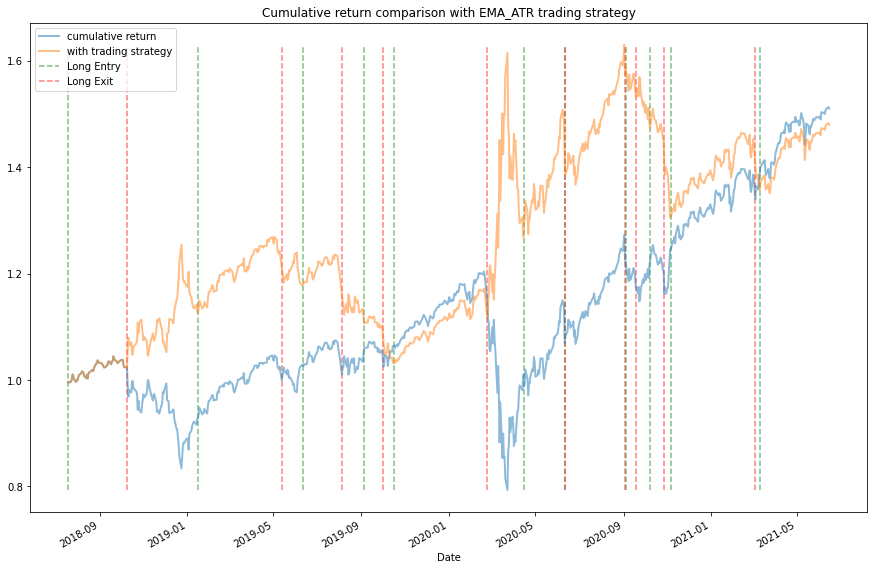

In [8]:
EMA_ATR(stock = stock, ema_s = 13, ema_l = 21, atr_n = 21, atr_mul = 3)

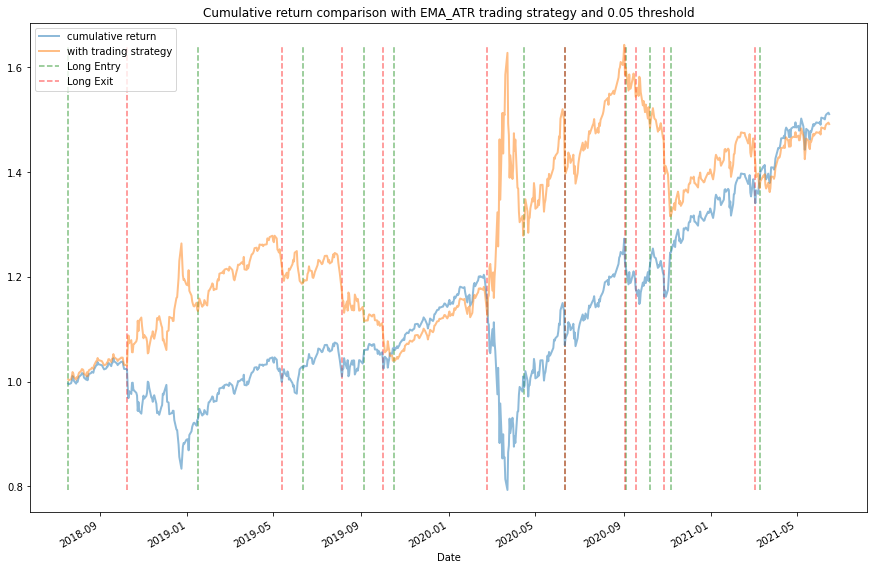

In [9]:
EMA_ATR_threshold(stock = stock, ema_s = 13, ema_l = 21, atr_n = 21, atr_mul = 3, threshold = 0.05)